In [172]:
import numpy as np
import pyBSS_code as pyBSS
import MakeSignal as ms
import astropy.io.fits as pyf
%matplotlib inline
import matplotlib.pyplot as plt

In [173]:
import numpy as np
import scipy.linalg as lng 
import copy as cp
#import nloptim as nlopt


# Preprocessing and Principal component analysis

On centre et on normalise les données

In [3]:
def whitening(X,A) :
    import numpy as np
    import scipy.linalg as lng 
    import copy as cp
    Xp=cp.copy(X)
    n=np.shape(Xp)[1]
    Yp = np.dot(np.diag(np.mean(Xp,axis=1)),np.ones(np.shape(Xp)))
    Xp = Xp - Yp
    Ry = np.dot(Xp,Xp.T)
    Dy, Uy = np.linalg.eig(Ry)
    X_tilde=np.dot(np.diag(1/np.sqrt(Dy)),Uy.T).dot(X)
    A_tilde=np.dot(np.diag(1/np.sqrt(Dy)),Uy.T).dot(A)
    
    return X_tilde,A_tilde

In [4]:
def low_rank_approx(SVD=None, A=None, r=1):
    """
    Computes an r-rank approximation of a matrix
    given the component u, s, and v of it's SVD
    Requires: numpy
    """
    if not SVD:
        SVD = np.linalg.svd(A, full_matrices=False)
    u, s, v = SVD
    Ar = np.zeros((len(u), len(v)))
    for i in xrange(r):
        Ar += s[i] * np.outer(u.T[i], v[i])
    return Ar

Sur des données issues d'un mélange de gaussiennes, une ACP ne permet pas de retrouver les sources, car sur ces données sphéricisées,
il n'y a pas de directions privilégiées.

In [175]:
X1,A1,S= pyBSS.GenerateMixture(n=2,m=2)

In [75]:
X,A=whitening(X1,A1)

In [76]:
Uy,Sy=pyBSS.Perform_PCA(X,2)

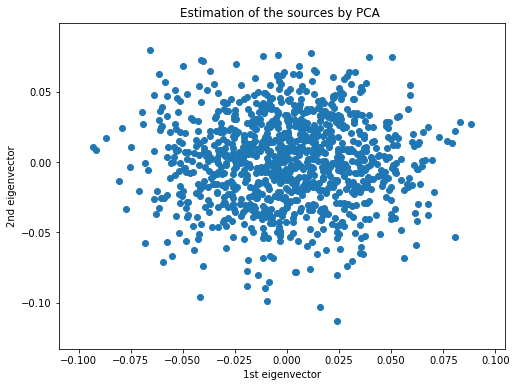

In [77]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(Sy[0,:],Sy[1,:],
           cmap=plt.cm.Paired)
ax.set_title("Estimation of the sources by PCA ")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
plt.show()


In [86]:
Ry = np.dot(X,X.T)
Dy, Uy = np.linalg.eig(Ry)
S_tilde=Uy[:,0:2].T.dot(X)

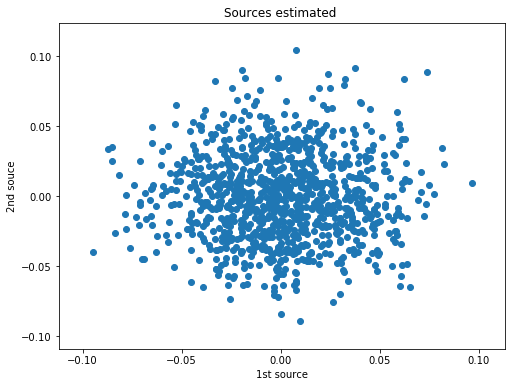

In [87]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(S_tilde[0, :], S_tilde[1, :],
           cmap=plt.cm.Paired)
ax.set_title("Sources estimated ")
ax.set_xlabel("1st source")
ax.set_ylabel("2nd souce")
plt.show()

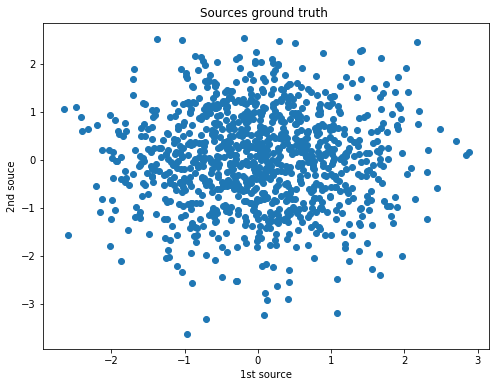

In [85]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(S[0, :], S[1, :],
           cmap=plt.cm.Paired)
ax.set_title("Sources ground truth ")
ax.set_xlabel("1st source")
ax.set_ylabel("2nd souce")
plt.show()

# Independent component analysis 

L'ICA consiste à proposer pour chaque source des lois marginales les plus indépendantes possibles : 
on minimise la distance de Kullback-Leiber entre la loi jointe et le produit des lois marginales.

On génère une loi uniforme sur un carré, on les mélange en appliquant une matrice de rotation. L'ICA permet de retrouver 
les sources à un facteur d'échelle près.

In [176]:
X,A,S=pyBSS.GenerateMixture(n=2,t=1024,m=8,p=0.02,SType=2,CdA = 1,noise_level = 120)

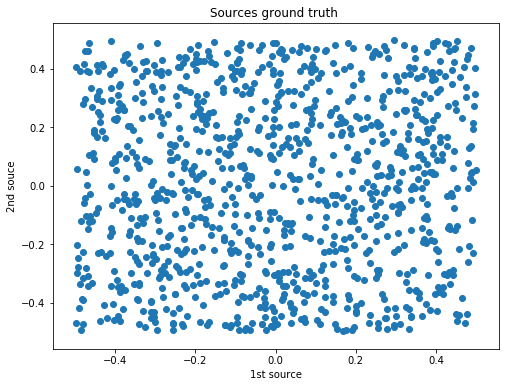

In [177]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(S[0, :], S[1, :],
           cmap=plt.cm.Paired)
ax.set_title("Sources ground truth ")
ax.set_xlabel("1st source")
ax.set_ylabel("2nd souce")
plt.show()

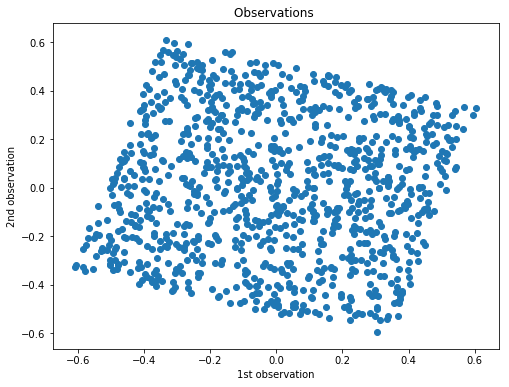

In [91]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(X[0, :], X[1, :],
           cmap=plt.cm.Paired)
ax.set_title("Observations ")
ax.set_xlabel("1st observation")
ax.set_ylabel("2nd observation")
plt.show()

In [178]:
n=2
A,S_tilde=pyBSS.Perform_FastICA(X,n);

In [179]:
np.shape(S_tilde)

(8, 1024)

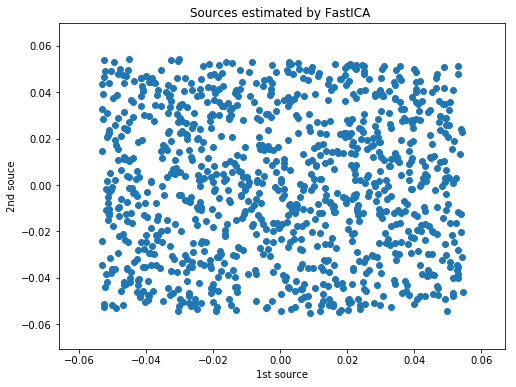

In [97]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(S_tilde[0, :], S_tilde[1, :],
           cmap=plt.cm.Paired)
ax.set_title("Sources estimated by FastICA ")
ax.set_xlabel("1st source")
ax.set_ylabel("2nd souce")
plt.show()

Les performances de l'ICA sont indépendantes du nombre de sources.

In [254]:
liste=[2,10,50,100];
taille=len(liste)
ordo=np.zeros(taille)
nb_iter=50
for ind,k in enumerate(liste) :
    for iter in range(nb_iter) :
        X,A0,S0=pyBSS.GenerateMixture(n=k,t=2**15,m=k,p=0.02,SType=2,CdA = 1,noise_level = 120)
        A,S=pyBSS.Perform_FastICA(X,k)
        res=pyBSS.Eval_BSS(A0,S0,A,S)
        ordo[ind]=ordo[ind]+res/nb_iter
    print(ordo[ind])

0.00311874368367
0.00340144402242
0.00340251696266
0.00341703179184


# Chandra

Chandra est un satellite d'observations, on montre ci-joint les images qu'il capte.

In [124]:
import astropy.io.fits as pyf
cmap = 'coolwarm'
hdulist=pyf.open('Data/AstroImages.fits')
hdulist.info()
#chandra = np.double(chandra.data)

Filename: Data/AstroImages.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      10   (256, 256, 3)   float32   


In [125]:
h = np.double(hdulist[0].data)
hdulist.close()

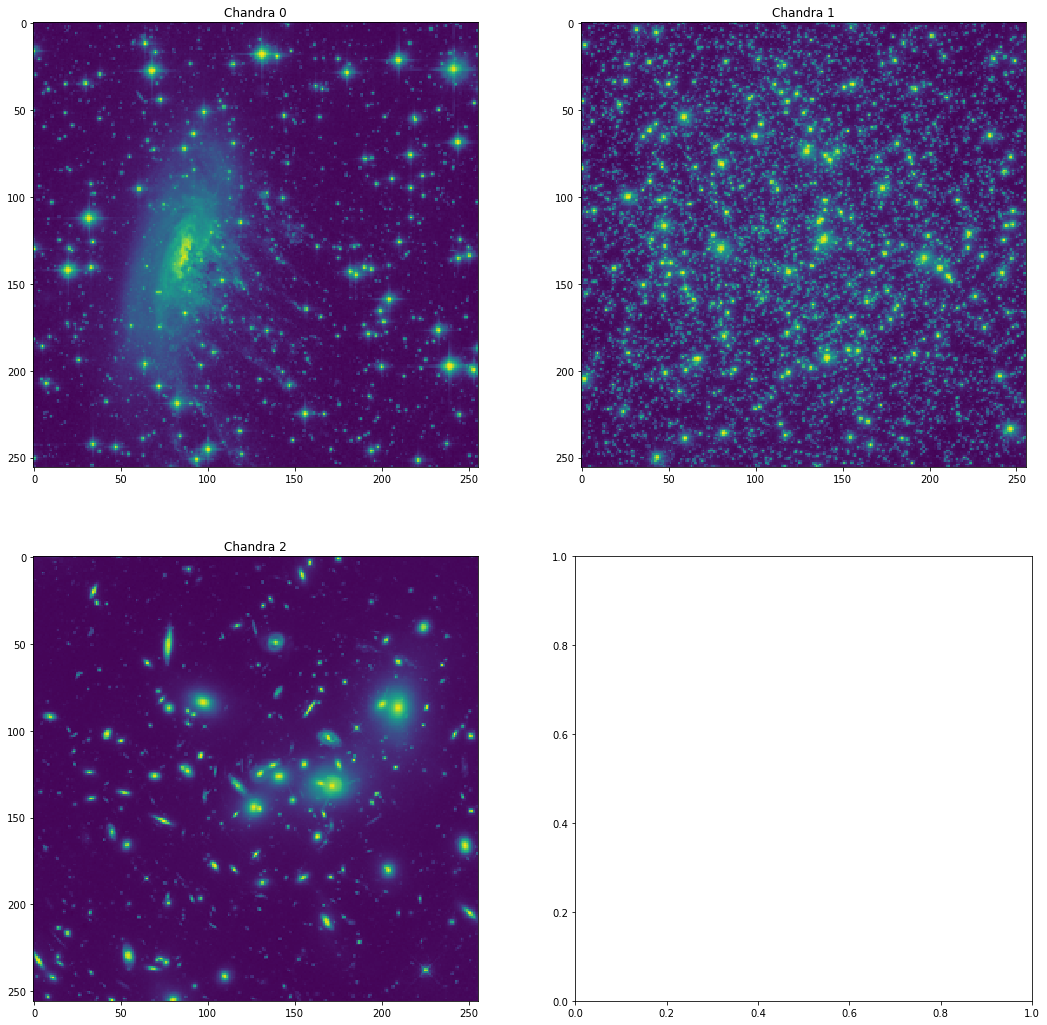

In [126]:
chandra=h.transpose(1,2,0)
#plt.imshow(h[0])
#plt.imshow(h[1])
#plt.imshow(h[2])
fig,ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(18, 18)
ax[0,0].imshow(h[0])
ax[0,0].set_title('Chandra 0')
ax[0,1].imshow(h[1])
ax[0,1].set_title('Chandra 1')
ax[1,0].imshow(h[2])
ax[1,0].set_title('Chandra 2')
fig.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

Ici le satellite relève des valeurs sur 8 canaux de fréquence différentes. Ces 8 canaux sont des mélanges de 8 sources.

In [180]:
import scipy.io
# load .mat file into dictionary x
x = scipy.io.loadmat('Data/chandra.mat')
S0=x['S0']
A0=x['A0']
Y=A0.dot(S0)
np.shape(A0),np.shape(S0)


((107, 8), (8, 7396))

In [181]:
np.shape(Y)

(107, 7396)

In [182]:
from sklearn.decomposition import FastICA
X = cp.copy(Y)
X = X.T
fpica = FastICA(n_components=8)

In [184]:
S = fpica.fit(X).transform(X).T  # Get the estimated sources
np.shape(S)
A = fpica.mixing_  # Get estimated mixing matrix
np.shape(S),np.shape(A)

((8, 7396), (107, 8))

In [170]:
k=8
A,S=pyBSS.Perform_FastICA(obs,8)

In [187]:
np.shape(A),np.shape(S)

((107, 8), (8, 7396))

In [189]:
res=pyBSS.Eval_BSS(A,S,A0,S0)

In [190]:
res

0.11632187203318413

Comme les sources sont sparses, la méthode donne de mauvais résultats : une distance de Froebenius de 0.1 
contre des valeurs de référence de 0.001

# 3. Sparse blind source separation : algo GMCA

Ici on mimimise la sparsité jointe de toutes les sources sous contrainte de fidélité aux données.

In [221]:
X,A0,S0=pyBSS.GenerateMixture(n=2,t=1024,m=2,p=0.02,SType=2,CdA = 1,noise_level = 120)

In [222]:
n=2
A,S,PinvA=pyBSS.Perform_GMCA(X,n,nmax=100,mints=0.5,maxts = 0)

On simule des sources qui suivent des lois uniformes. La méthode va ici forcer la sparsité, 
alors que les sources ne sont pas sparses.

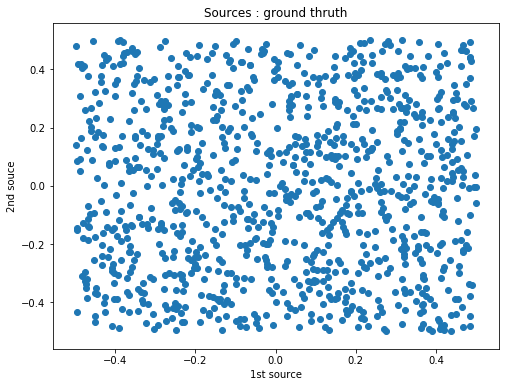

In [224]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(S0[0, :], S0[1, :],
           cmap=plt.cm.Paired)
ax.set_title("Sources : ground thruth")
ax.set_xlabel("1st source")
ax.set_ylabel("2nd souce")
plt.show()

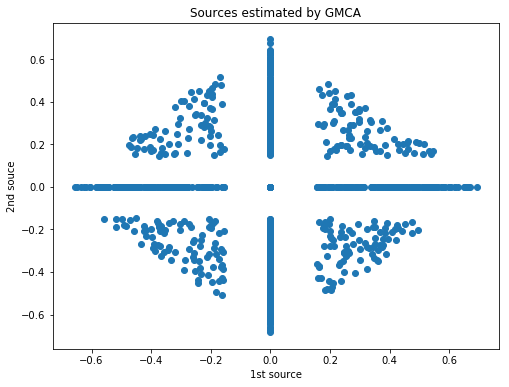

In [223]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(S[0, :], S[1, :],
           cmap=plt.cm.Paired)
ax.set_title("Sources estimated by GMCA")
ax.set_xlabel("1st source")
ax.set_ylabel("2nd souce")
plt.show()

# sparse

Par contre,sur des données vraiment sparses ( ici simulées), la méthode donne de bons résultats.

In [438]:
X,A0,S0=pyBSS.GenerateMixture(n=2,t=1024,m=2,p=0.02,SType=3,CdA = 1,noise_level = 120)
n=2
A,S,PinvA=pyBSS.Perform_GMCA(X,n,nmax=100,mints=0.5,maxts = 0)

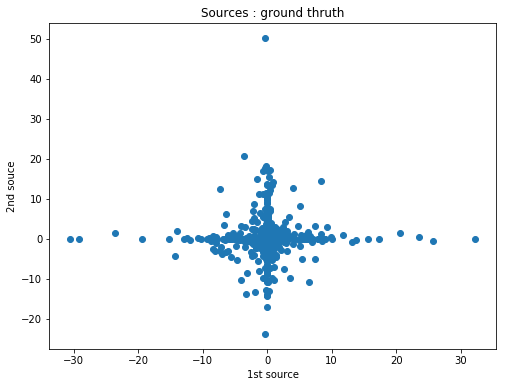

In [437]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(S0[0, :], S0[1, :],
           cmap=plt.cm.Paired)
ax.set_title("Sources : ground thruth")
ax.set_xlabel("1st source")
ax.set_ylabel("2nd souce")
plt.show()

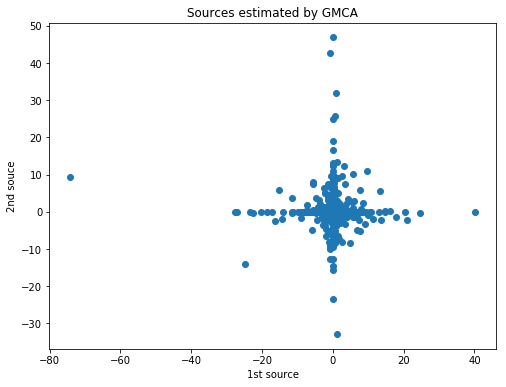

In [439]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(S[0, :], S[1, :],
           cmap=plt.cm.Paired)
ax.set_title("Sources estimated by GMCA")
ax.set_xlabel("1st source")
ax.set_ylabel("2nd souce")
plt.show()

In [228]:
np.var(X[1,:])

16.095094434573426

In [229]:
sigma=min(np.var(X[0,:]), np.var(X[1,:])   );
sigma

3.8325212593194773

In [249]:
def noise(X,sigma, coeff) :
    return np.sqrt(1/coeff)*sigma*np.random.randn(np.shape(X)[0], np.shape(X)[1])

In [252]:
coeff=10
Y=X+noise (X,sigma, coeff)
A,S,PinvA=pyBSS.Perform_GMCA(Y,n,nmax=100,mints=0.5,maxts = 0)


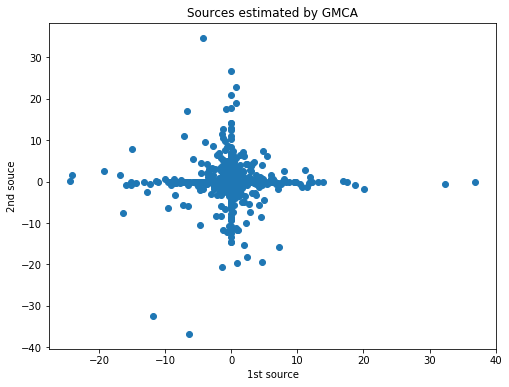

In [253]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(S[0, :], S[1, :],
           cmap=plt.cm.Paired)
ax.set_title("Sources estimated by GMCA")
ax.set_xlabel("1st source")
ax.set_ylabel("2nd souce")
plt.show()

In [259]:
liste=[40, 30, 20, 10];
taille=len(liste)
ordo=np.zeros(taille)
nb_iter=50
for ind,k in enumerate(liste) :
    for iter in range(nb_iter) :
        X,A0,S0=pyBSS.GenerateMixture(n=2,t=1024,m=2,p=0.02,SType=3,CdA = 1,noise_level = 120)
        Y=X+noise (X,sigma,liste[ind])
        n=2
        A,S,PinvA=pyBSS.Perform_GMCA(Y,n,nmax=100,mints=0.5,maxts = 0)
        res=pyBSS.Eval_BSS(A0,S0,A,S)
        ordo[ind]=ordo[ind]+res/nb_iter
    print(ordo[ind])

0.00138843265373
0.00119736401963
0.00116005842832
0.00120242403363


# Going further with sparse BSS

In [260]:
import numpy as np
import scipy.linalg as lng 
import copy as cp
def Perform_GMCA(X,n,nmax=100,mints=0.5,maxts = 0):

	z = np.shape(X)
	t = z[1]
	m = z[0]

	A = np.random.randn(m,n)
	for r in range(0,n):
		A[:,r] = A[:,r]/lng.norm(A[:,r])
		
	Ra = np.dot(A.T,A)
	S = np.dot(np.diag(1./np.diag(Ra)),np.dot(A.T,X))	

	ts = 0
	if maxts == 0:
		for r in range(1,n):
			maxts = np.max([np.max(abs(S[r,:]))/mad(S[r,:]),ts])
				
	vts = np.exp((np.log(maxts) - np.log(mints))*np.linspace(0,1,nmax)[::-1] + np.log(mints))
	vepsilon = np.power(10,4*np.linspace(0,1,nmax)[::-1] - 5)
	
	for nit in range(0, nmax):
		
		# Estimate the sources for fixed A
		
		epsilon = vepsilon[nit]
		ts = vts[nit]
		
		Ra = np.dot(A.T,A)
		mRa = lng.norm(Ra,2)
		
		Ra = Ra + epsilon*mRa*np.identity(n)
		PinvA = np.dot(lng.inv(Ra),A.T)
		S = np.dot(PinvA,X)
		
		for ns in range(0, n):
			temp = S[ns,:]
			thrd = ts*mad(temp)
			S[ns,(abs(temp) < thrd)] = 0	
			
				
		# Estimate the mixing matrix for fixed sources S
		
		vs = np.sqrt(np.sum(S*S,axis=1))
		
		indA = np.where(vs > 1e-6)		
		indA = indA[0]
						
		nactive = len(indA)
															
		if nactive > 1:
		
			temp = S[indA,:]
			Rp = np.dot(temp,temp.T)
			mRp = lng.norm(Rp,2)
			Rp = Rp + epsilon*mRp*np.identity(nactive)
			PinvS = np.dot(temp.T,lng.inv(Rp))
			A[:,indA] = np.dot(X,PinvS)
			
			for ns in indA:
				A[:,ns] = 	A[:,ns]/float(lng.norm(A[:,ns] + 1e-6))
				if lng.norm(A[:,ns]) < 1e-6:
					A[:,ns] = np.random.randn(m)
													
	return A,S,PinvA

Ci-dessous, on minimise la somme des sparsités de chaque source sous contrainte de fidélité aux données (
au lieu de minimiser la sparsité toute sources confondues) et le résultat est similaire.

In [555]:
def Perform_GMCA(X,n,nmax=100,mints=0.5,maxts = 0):

    z = np.shape(X)
    t = z[1]
    m = z[0]

    A = np.random.randn(m,n)
    for r in range(0,n):
        A[:,r] = A[:,r]/lng.norm(A[:,r])

    Ra = np.dot(A.T,A)
    S = np.dot(np.diag(1./np.diag(Ra)),np.dot(A.T,X))	

    ts = 0
    if maxts == 0:
        for r in range(1,n):
            maxts = np.max([np.max(abs(S[r,:]))/pyBSS.mad(S[r,:]),ts])

    vts = np.exp((np.log(maxts) - np.log(mints))*np.linspace(0,1,nmax)[::-1] + np.log(mints))
    vepsilon = np.power(10,4*np.linspace(0,1,nmax)[::-1] - 5)

    epsilon = vepsilon[0]
    ts = vts[0]

        
        
    Ra = np.dot(A.T,A)
    mRa = lng.norm(Ra,2)

    Ra = Ra + epsilon*mRa*np.identity(n)
    PinvA = np.dot(lng.inv(Ra),A.T)
    S = np.dot(PinvA,X)
    
    
    for nit in range(1, nmax):
        # Estimate the sources for fixed A

        epsilon = vepsilon[nit]
        ts = vts[nit]
        
        #print("nit=" +repr(nit) )        
        for ns in range(0,n):
            ligne = S[ns,:]
            thrd = ts*pyBSS.mad(ligne)
            colonne=A[:,ns]
            PinvA_k= np.ravel(lng.pinv([colonne]))
            
            #print('ligne'+repr(np.shape(ligne)))
            #print('colonne'+repr(np.shape(colonne)))
            mat=np.outer(colonne,ligne)
            #print('mat'+repr(np.shape(mat)))
            
            Z= X- ( np.dot(A,S)-mat)
            #print('Z'+repr(np.shape(Z)))
    
            S_k=np.dot(PinvA_k,Z )
            #print('PinvA_k'+repr(np.shape(PinvA_k)))
        
            S_k[abs(S_k)<thrd]=0
            S[ns,:]=S_k           
            #print(S)
                                
        # Estimate the mixing matrix for fixed sources S
        vs = np.sqrt(np.sum(S*S,axis=1))

        indA = np.where(vs > 1e-6)		
        indA = indA[0]
        nactive = len(indA)

        
        if nactive > 1:

            temp = S[indA,:]
            Rp = np.dot(temp,temp.T)
            mRp = lng.norm(Rp,2)
            Rp = Rp + epsilon*mRp*np.identity(nactive)
            PinvS = np.dot(temp.T,lng.inv(Rp))
            A[:,indA] = np.dot(X,PinvS)

            for ns in indA:
                A[:,ns] = 	A[:,ns]/float(lng.norm(A[:,ns] + 1e-6))
                if lng.norm(A[:,ns]) < 1e-6:
                    A[:,ns] = np.random.randn(m)

    return A,S

In [569]:
A,S=Perform_GMCA(X,n,nmax=100,mints=0.5,maxts = 0)

In [563]:
n=8
X,A0,S0=pyBSS.GenerateMixture(n=n,t=2**15,m=n,p=0.02,SType=3,CdA = 1,noise_level = 120)

In [565]:
pyBSS.Eval_BSS(A0,S0,A,S)

0.00018477940105413433

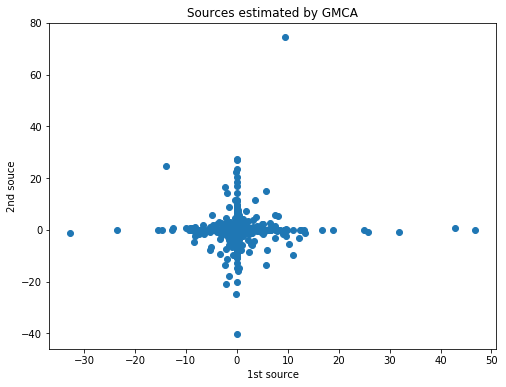

In [446]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(S[0, :], S[1, :],
           cmap=plt.cm.Paired)
ax.set_title("Sources estimated by GMCA")
ax.set_xlabel("1st source")
ax.set_ylabel("2nd souce")
plt.show()

# Chandra

In [ ]:
Sur les données de Chandra qui sont sparse, la méthode GMCA fonctionne.

In [567]:
import scipy.io
# load .mat file into dictionary x
x = scipy.io.loadmat('Data/chandra.mat')
S0=x['S0']
A0=x['A0']
X=A0.dot(S0)
np.shape(A0),np.shape(S0)

((107, 8), (8, 7396))

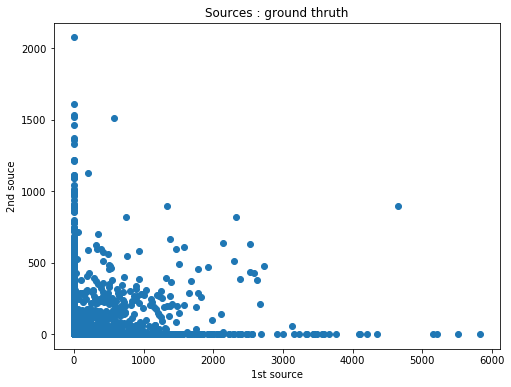

In [568]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(S0[0, :], S0[1, :],
           cmap=plt.cm.Paired)
ax.set_title("Sources : ground thruth")
ax.set_xlabel("1st source")
ax.set_ylabel("2nd souce")
plt.show()

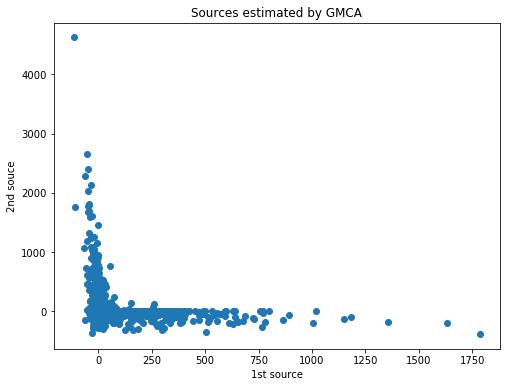

In [573]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(S[0, :], S[1, :],
           cmap=plt.cm.Paired)
ax.set_title("Sources estimated by GMCA")
ax.set_xlabel("1st source")
ax.set_ylabel("2nd souce")
plt.show()

In [484]:
np.shape(np.outer(A0[1,:],S0[1,:]))

(8, 7396)

In [571]:
n=8
A,S,PinvA=pyBSS.Perform_GMCA(X,n,nmax=100,mints=0.5,maxts = 0)

In [ ]:
pyBSS.Eval_BSS(A0,S0,A,S)

In [ ]:
A,S=Perform_GMCA(X,n,nmax=100,mints=0.5,maxts = 0)
pyBSS.Eval_BSS(A0,S0,A,S)